In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# change to False, if you are not using dark mode
dark_mode = False

# adapts matplotlib color settings to work with dark mode

if dark_mode:
    text_color = "white"
    face_color = "black"
else:
    text_color = "black"
    face_color = "grey"
plt.rcParams['text.color'] = text_color
plt.rcParams['axes.labelcolor'] = text_color 
plt.rcParams['xtick.color'] = text_color
plt.rcParams['ytick.color'] = text_color
plt.rcParams['legend.facecolor'] = face_color

# Numerical Bifurcation Analysis

<br/>

In this notebook, you will apply methods such as numerical parameter continuation and automated bifurcation analysis via a high-level interface to Auto-07p.
We will continue to work with the Izhikevich neuron as an example model, but study bifurcations at the network level, rather than the single-neuron level.

<br/>

## Mean-field equations for Spiking Neural Networks

<br/>

In the previous notebook, we studied networks of coupled spiking neurons.
Due to the discontinuity around the spike (due to the resetting mechanism), we cannot study these networks via tools from bifurcation analysis.

This is why, in this part, we study mean-field equations of the network dynamics instead.
We have learned already that network-wide quantities such as the average membrane potential are the crucial information carrying variables when it comes to the dynamic state that the entire network is in.
Mean-field equations provide the means to study these network-wide quantities directly.
They are continous-valued models that have been derived from the spiking neural network equations.
This relationship is depicted below:

<img src="img/neco_micro_macro.png" width="800">

The particular set of mean-field equations for networks of coupled Izhikevich neurons that we will study is provided below:

$$ C \dot{r} = \frac{\Delta_v k^2 \sigma_v}{\pi C} (v-v_r) + r[k(2 v - v_r - \bar v_{\theta}) - g s],$$
$$ C \dot{v} = k v(v -v_r-\bar v_{\theta}) - \pi C r(\Delta_v \sigma_v + \frac{\pi C}{k} r) + k v_r \bar v_{\theta} - u + I  + g s (E-v), $$
$$ \tau_u \dot{u} = b(v-v_r) - u + \tau_u \kappa r, $$
$$ \tau_s \dot{s} = -s + \tau_s J r. $$

For more information on how these mean-field equations can be derived from the network equations of coupled Izhikevich neurons, see [this paper](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.107.024306).
Importantly, these four coupled differential equations approximatively capture the dynamics of the average firing rate $r$, the average membrane potential $v$, the average recovery variable $u$, and the global synaptic input $s$ of an Izhikevich neural network with distributed spike thresholds $v_t$.

It is this set of equations and its parameter dependencies that we will study via bifurcation analysis below.

## Parameter Continuations via PyCoBi

To study how the equilibrium structure of the mean-field equations changes as a function of one of its parameter, we can use [numerical continuation](https://en.wikipedia.org/wiki/Numerical_continuation).

<br/>

However, as a first step, we have to find a stable solution of the system dynamics.
Every numerical continuation algorithm requires a stable solution for a particular choice of the parameter.
Based on this initial solution, the algorithm can then detect how small changes in the parameter translate to changes in the stable solution.

<br/>

Let's find such a solution via a numerical simulation for a particular parameter set of our mean-field equations.
To this end, we use the pre-implemented mean-field equations in the dynamical systems modeling tool [PyRates](https://github.com/pyrates-neuroscience/PyRates).

<br/>

Let's run the cell below to perform the simulation and observe whether the model converged to a stable solution.

In [2]:
from pyrates import CircuitTemplate

# initialize mean-field model
ik_mf = CircuitTemplate.from_yaml("ik/ik_mf")
 
# define the model parameters
var_values = {"C": 100.0, "k": 0.7, "v_r": -60.0, "v_t": -40.0, "b": -2.0, "g": 15.0, "tau_u": 33.33, 
              "kappa": 10.0, "tau_s": 6.0, "E_r": 0.0, "eta": 70.0, "Delta": 1.0, "I_ext": 0.0}

# define an initial state (not required, by default all state variables are 0)
var_values.update({"r": 0.0, "v": -40.0, "u": 0.0, "s": 0.0})

# create a variable name map that maps the parameter/state variable names to the pyrates naming scheme
vmap = {key: f"p/ik_mf_op/{key}" for key in var_values}

# define simulation parameters (time unit: ms)
T = 1000.0
dt = 1e-2
sr = 100

# update the model parameters and state variable values
ik_mf.update_var(node_vars={vmap[key]: val for key, val in var_values.items()})

# perform mean-field simulation
res = ik_mf.run(simulation_time=T, step_size=dt, sampling_step_size=int(dt*sr), 
                outputs={"v": vmap["v"], "r": vmap["r"]}, 
                in_place=False, solver="scipy", atol=1e-7, rtol=1e-7)

Compilation Progress
--------------------
	(1) Translating the circuit template into a networkx graph representation...
		...finished.
	(2) Preprocessing edge transmission operations...
		...finished.
	(3) Parsing the model equations into a compute graph...
		...finished.
	Model compilation was finished.
Simulation Progress
-------------------
	 (1) Generating the network run function...
	 (2) Processing output variables...
		...finished.
	 (3) Running the simulation...
		...finished after 0.12036063300001842s.


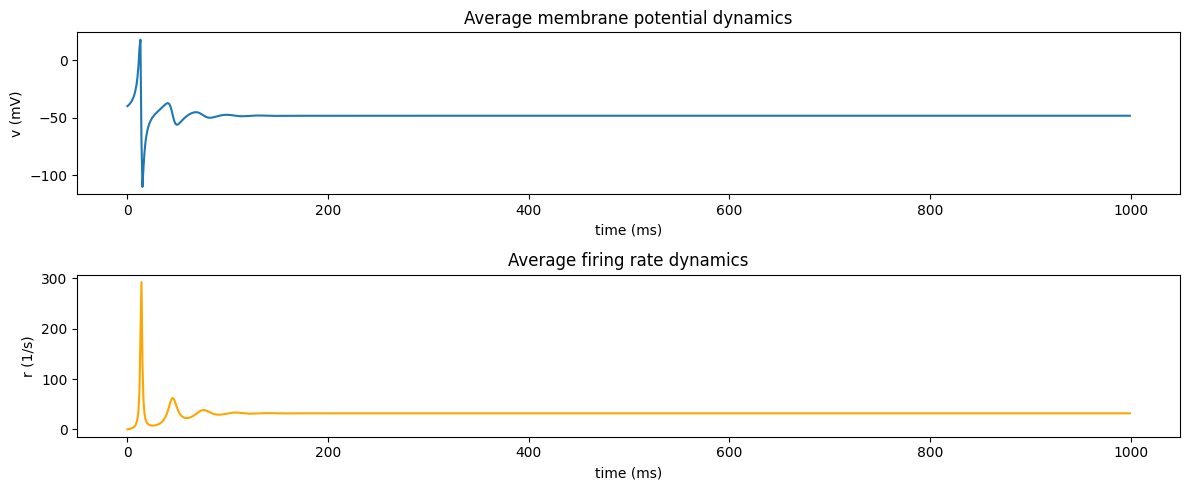

In [3]:
# plot results
_, axes = plt.subplots(nrows=2, figsize=(12, 5))
ax = axes[0]
ax.plot(res["v"])
ax.set_xlabel("time (ms)")
ax.set_ylabel("v (mV)")
ax.set_title("Average membrane potential dynamics")
ax = axes[1]
ax.plot(res["r"]*1e3, color="orange")
ax.set_xlabel("time (ms)")
ax.set_ylabel("r (1/s)")
ax.set_title("Average firing rate dynamics")
plt.tight_layout()

As we can see from the dynamics in the two state variables $v$ and $r$, the model seems to have converged to a stable state after initial fluctuations.
We can thus use the value of the state variables at the end of this simulation for parameter continuations.

<br/>

To run parameter continuations, PyCoBi will require user-supplied Fortran files that contain the model equations, parameters, and meta parameters for Auto-07p.
Don't worry, you wont have to write Fortran code yourself.

<br/>

PyRates provides a simple function call, which creates all necessary Fortran user files and writes them to a file in your working directory.
It will automatically use the lates values of all state variables and model parameters and thus make use of the stable state solution we just found. 
Execute the cell below to generate these files.

<br/>

For a more detailed explanation of the `CircuitTemplate.get_run_func` method, see [this use example](https://pyrates.readthedocs.io/en/latest/auto_analysis/continuation.html).

In [4]:
_, _, params, state_vars = ik_mf.get_run_func(
    func_name='ik_rhs', file_name='ik', step_size=dt, auto=True, backend='fortran', solver='scipy', 
    vectorize=False, float_precision='float64', in_place=False
)

Compilation Progress
--------------------
	(1) Translating the circuit template into a networkx graph representation...
		...finished.
	(2) Preprocessing edge transmission operations...
		...finished.
	(3) Parsing the model equations into a compute graph...
		...finished.
	Model compilation was finished.


To perform parameter continuations as well as automated bifurcation analysis, we will use the software [PyCoBi](https://github.com/pyrates-neuroscience/PyCoBi), which is a Python wrapper to the Fortran software [Auto-07p](https://github.com/auto-07p/auto-07p). 
We can create a simple instance of the main PyCoBi class for parameter continuations and bifurcation analysis via the following line:

In [5]:
from pycobi import ODESystem

cont = ODESystem("ik", working_dir=None, auto_dir="/home/auto-07p", init_cont=False, 
                 params=params[3:], state_vars=list(state_vars))

FileNotFoundError: [Errno 2] No such file or directory: '/home/auto-07p/cmds'

Let's have a look at the file that was created. This is what PyCoBi will use in the background to run fortran-based paramter continuations and bifurcation analysis:

In [6]:
f = open('ik.f90', 'r')
print('')
print(f.read())


module ik

double precision :: PI = 4.0*atan(1.0)

contains


subroutine ik_rhs(t,y,dy,v_t,v_r,k,g,Delta,C,E_r,I_ext,eta,b,tau_u,&
     & kappa,tau_s)

implicit none

double precision, intent(in) :: t
double precision, intent(in) :: y(4)
double precision :: r
double precision :: v
double precision :: u
double precision :: s
double precision :: s_in
double precision, intent(inout) :: dy(4)
double precision, intent(in) :: v_t
double precision, intent(in) :: v_r
double precision, intent(in) :: k
double precision, intent(in) :: g
double precision, intent(in) :: Delta
double precision, intent(in) :: C
double precision, intent(in) :: E_r
double precision, intent(in) :: I_ext
double precision, intent(in) :: eta
double precision, intent(in) :: b
double precision, intent(in) :: tau_u
double precision, intent(in) :: kappa
double precision, intent(in) :: tau_s


r = y(1)
v = y(2)
u = y(3)
s = y(4)
s_in = s

dy(1) = (r*(-g*s_in + k*(2.0*v - v_r - v_t)) + Delta*k**2*(v - v_r)&
     & /(pi*C))/C
dy

Now we are ready to run parameter continuations via PyCoBi.

<br/>

### (I) Continuation of a known steady-state solution in one parameter

<br/>

As a first example, we will continue the solution that we obtained above in the parameter $\eta$, which can be viewed as a background input.
From reading in the Fortran file, we saw that $\eta$ is the $9$th parameter of the model. 
The cell below performs a continuation of the solution that we found previously in $\eta$:

In [7]:
algorithm_params = {"NTST": 400, "NCOL": 4, "IAD": 3, "IPLT": 0, "NBC": 0, "NINT": 0, "NMX": 8000, "NPR": 100,
                    "MXBF": 5, "IID": 2, "ITMX": 40, "ITNW": 40, "NWTN": 12, "JAC": 0, "EPSL": 1e-7, "EPSU": 1e-7,
                    "EPSS": 1e-7, "DS": 1e-3, "DSMIN": 1e-10, "DSMAX": 2e-2, "IADS": 1, "THL": {}, "THU": {}}

# perform a continuation in eta
_ = cont.run(bidirectional=True, name="eta:1", c="ivp", ICP=vmap["eta"], IPS=1, ILP=1, ISP=2, ISW=1, RL0=-10.0, RL1=90, 
             UZR={vmap["eta"]: 0.0}, STOP={}, **algorithm_params)

gfortran -g -fopenmp -O -c ik.f90 -o ik.o
gfortran -g -fopenmp -O ik.o -o ik.exe /home/rgf3807/PycharmProjects/auto-07p/lib/*.o
Starting ik ...

  BR    PT  TY  LAB    PAR(9)        L2-NORM         U(1)          U(2)          U(3)          U(4)     
   1     1  EP    1   7.00000E+01   4.99878E+01   3.18766E-02  -4.83577E+01  -1.26602E+01   1.91260E-01
   1   100        2   7.19031E+01   4.99447E+01   3.22405E-02  -4.83306E+01  -1.25930E+01   1.93443E-01
   1   200        3   7.39017E+01   4.99004E+01   3.26150E-02  -4.83029E+01  -1.25237E+01   1.95690E-01
   1   300        4   7.59004E+01   4.98571E+01   3.29822E-02  -4.82757E+01  -1.24556E+01   1.97893E-01
   1   400        5   7.78991E+01   4.98147E+01   3.33424E-02  -4.82492E+01  -1.23886E+01   2.00054E-01
   1   500        6   7.98978E+01   4.97732E+01   3.36960E-02  -4.82232E+01  -1.23227E+01   2.02176E-01
   1   600        7   8.18966E+01   4.97325E+01   3.40435E-02  -4.81977E+01  -1.22579E+01   2.04261E-01
   1   700        8   

   1  5977  EP   64  -1.00144E+01   6.08507E+01  -8.53175E-05  -6.08289E+01   1.62929E+00  -5.11905E-04

 Total Time    0.171E+00
ik ... done
Merge done


These few lines of code returned an entire branch of steady-state solutions with all detected bifurcation points along the branch.
In other words, PyCoBi just iteratively applied a [numeric continuation algorithm](https://en.wikipedia.org/wiki/Numerical_continuation) such as Gauss-Newton continuation or pseudo-arclength continution for new values the continuation parameter $\eta$, until a stopping criterion was reached.
Furthermore, the software monitored the eigenvalue spectrum of the local linearization of the systems' vectorfield to detect bifurcations and applied normal form analysis to localize the bifurcation point. 

Let's go through the most relevant control parameters for PyCoBi that were used in the `ODESystem.run` call above, to understand how we instructed PyCoBi to do all this for us. 

<br/>

The first argument that we use is `bidirectional=True`. If this is set to true, PyCoBi will automatically run two continuations: One where it will continue the solution curve for decreasing values of the continuation paramter, and one where it will continue the solution curve for increasing values of the continuation paramter. Sometimes, you are only interested in one particular continuation direction. In this case, you can set `bidirectional=False`, which is also the default behavior. 

<br/>

The second parameter we set is `name="eta"`. This tells PyCoBi under which name to store the resulting solution curve, so that you can start from a particular solution on this curve, if you want to run follow-up continuations (we will see this in action below).

<br/>

The third argument that we use is `c="ivp"`. This tells PyCoBi that there exists a meta parameter file called `c.ivp` in the same directory, where also the equation file `ik.f90` is located, that contains all the meta parameters that control the numerical algorithms that PyCoBi runs via Auto-07p in the background.
We will not bother with explaining most of the parameters that control specific details of the numerical parameter continuation and bifurcation detection algorithms. Instead, we will focus on those parameters that you will always need to change depending on which continuation problem you are facing.
The parameters that we won't explain are those listed in the dictionary `algorithm_params`. We re-defined them here to choose an optimal set of default parameters for all continuations that we will perform. 
For a detailed explanation of those parameters, have a look at the [Auto-07p documentation](https://github.com/auto-07p/auto-07p/tree/master/doc).

<br/>

All other keyword argument that follow are Auto-o7p parameters that overwrite the default behavior as defined in `c.ivp`.
Here is a quick overview of what they do:

- `ICP`: This is the most important Auto-07p parameter. It is used to specify the continuation parameter(s). You can either pass a single or multiple continuation parameters. Also, you can either use the index of the continuation parameter in the `args` vector of the `subroutine stpnt` in the `ik.f90` file, or simply use the string-based name of the parameter.

- `IPS`: This defines the basic problem type for which to run continuations. `IPS=1` corresponds to the continuation of a steady-state solution of an ODE system, whereas `IPS=2` corresponds to the continuation of a periodic solution of an ODE system. There exist many other options for `IPS`, but those we will not cover as part of this tutorial. 

- `ILP`: This parameter can be used to toggle fold bifurcation detection on (`ILP=1`) or off (`ILP=0`). Turn this off for any continuation where you don't expect fold bifurcations to appear (e.g. parameter continuations with two independent continuation parameters).

- `ISP`: This controls the detection of any bifurcations related to periodic solutions, such as Hopf bifurcations, period doubling bifurcations, and torus bifurcations. The most important options here are `ISP=0` (turn off detection of bifurcations related to periodic solutions), `ISP=1` (enable calculation of floquet multipliers for periodic solutions), and `ISP=2` (turn of floquet multipler calculation and bifurcation detection).

- `ISW`: This controls the switching behavior between solution branches that collide at a bifurcation point. Important options here are: `ISW=1` (standard behavior, no branch switching is done at special solutions for ODEs), `ISW=2` (allows the calculation of a curve of special solutions such as fold/hopf bifurcations in 2-3 continuation parameters), and `ISW=-1` (switch the branch at a branching point such as a hopf bifurcation or a period doubling bifurcation and perform continuation of this branch).

- `RL0` and `RL1`: The minimum and maximum value that the main continuation parameter should take on.

- `UZR`: This allows to mark solutions where the continuation parameter takes on a specific value. For example, if `UZR={"eta": 0.0}` the solution where $\eta = 0.0$ pA will be marked as a special solution with tag "UZ1", which can be used for follow-up continuations.

- `STOP`: This allows to define a stopping criterion for the parameter continuation. For example, `STOP=["UZ1"]` defines that the parameter continuation is supposed to stop at the first solution that the algorithm encounters, which meets one of the criteria defined in `UZR`.

- `NPR`: This is the sampling rate for the solutions along the solution branch. `NPR=100` means that every 100th solution of the continuation procedure is stored for plotting etc.

- `NMX`: This controls the maximum number of continuation steps. `NMX=8000` means that the continuation will stop, after it has performed 4000 iterations of the algorithm, no matter what the value of the continuation parameter is at this point.

- `DSMAX`: This controls the maximum step-size that the algorithm is allowed to make when increasing/decreasing the continuation parameter.

These are all the crucial parameters that you will need to know in order to run basic bifurcation analyses via PyCoBi.
Let's have a look at the bifurcation diagram from the parameter continuation we just ran:

In [6]:
# plot the 1D bifurcation diagram
cont.plot_continuation(vmap["eta"], vmap["r"], cont="eta:1")
plt.title("1D bifurcation diagram of a steady-state solution")
plt.show()

NameError: name 'cont' is not defined

This bifurcation diagram shows you the value of $r$ (y-axis) for a set of steady-state solutions with different values of $\eta$ (x-axis).
In addition, it shows you the stability of a solution at a given $\eta$ via the line type: Solid lines indicate stable solutions, whereas dotted lines indicate unstable solutions.
The steady-state solution curve changes stability twice in the investigated parameter regime. Both times, a stable solution branch looses stability via a fold bifurcation (labeled "LP" in the bifurcation diagram for it's alternative name: limit point bifurcation) and gives rise to a branch of unstable solutions.
Within the parameter regime bounded by the two fold bifurcations, two stable solution branches exist.
Thus, for any value of $\eta$ within that parameter regime, the Izhikevich mean-field equations can converge to one of two stable states, depending on its initial conditions.
This explains the hysteresis behavior we observed earlier in the spiking neural network.

<br/>

Let's confirm the predictions of the bifurcation diagram again via a numerical simulation, where we initialize the system in the bi-stable regime at $\eta = 30$ pA and choose an initial condition such that the system converges to the low activity state. Then, we will apply a short extrinsic stimulation that effectively pushes the system over a fold bifurcation to $\eta = 50$ pA, thus inducing a transition to the high activity state.
We will then turn off the extrinsic stimulus and observe whether the system will linger around the high-activity state, thus prooving the existence of a second stable equilibrium, or whether it will transition back to its original state.

Compilation Progress
--------------------
	(1) Translating the circuit template into a networkx graph representation...
		...finished.
	(2) Preprocessing edge transmission operations...
		...finished.
	(3) Parsing the model equations into a compute graph...
		...finished.
	Model compilation was finished.
Simulation Progress
-------------------
	 (1) Generating the network run function...
	 (2) Processing output variables...
		...finished.
	 (3) Running the simulation...
		...finished after 1.0750490329992317s.


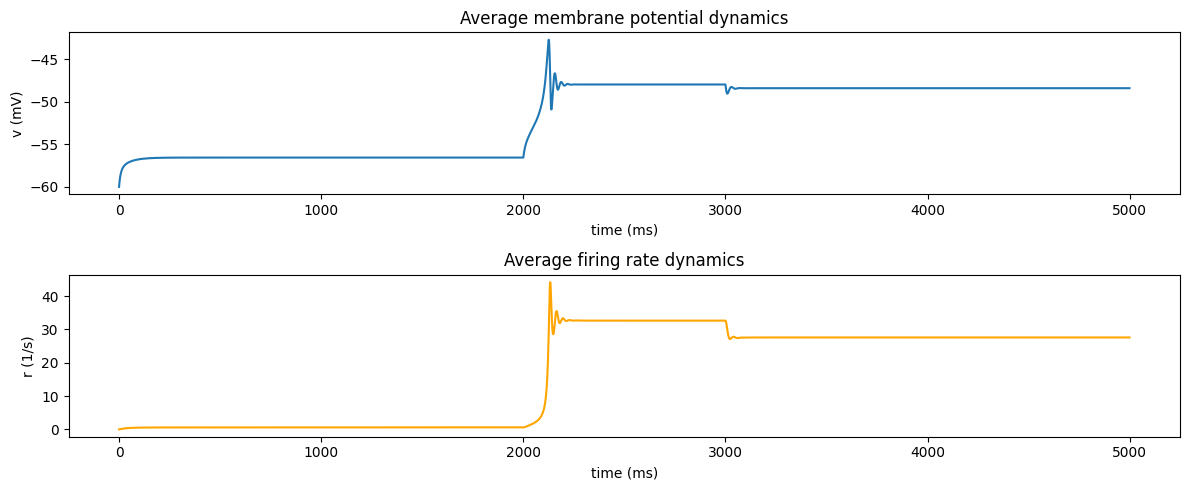

In [9]:
# define simulation parameters (time unit: ms)
T = 5000.0
dt = 1e-2
sr = 100

# define extrinsic input
start = int(2000.0/dt)
dur = int(1000.0/dt)
steps = int(T/dt)
inp = np.zeros((steps,))
inp[start:start+dur] = 20.0

# update model parameters and initial state
variables = {"eta": 30.0, "r": 0.0, "v": -60.0, "u": 0.0, "s": 0.0}
ik_mf.update_var(node_vars={vmap[key]: val for key, val in variables.items()})

# perform mean-field simulation
res = ik_mf.run(simulation_time=T, step_size=dt, sampling_step_size=int(dt*sr), 
                outputs={"v": vmap["v"], "r": vmap["r"]}, inputs={vmap["I_ext"]: inp},
                in_place=False, solver="scipy", atol=1e-7, rtol=1e-7)

# plot results
_, axes = plt.subplots(nrows=2, figsize=(12, 5))
ax = axes[0]
ax.plot(res["v"])
ax.set_xlabel("time (ms)")
ax.set_ylabel("v (mV)")
ax.set_title("Average membrane potential dynamics")
ax = axes[1]
ax.plot(res["r"]*1e3, color="orange")
ax.set_xlabel("time (ms)")
ax.set_ylabel("r (1/s)")
ax.set_title("Average firing rate dynamics")
plt.tight_layout()

As we can see from the resulting dynamics, the system stays in a high activity state after we turn off the stimulation at $t = 3000$ ms.
Thus the system converged to a low activity state prior to the stimulus onset at $t = 2000$ ms, but converged to a high activity state after stimulation, despite the value of $\eta$ (and all other model parameters) being the same in both cases.
Thus, the system expresses two distinct stable equilibria at $\eta = 30$ pA.

<br/>

### (II) Continuation of a periodic solution in one parameter

<br/>

In the previous hands-on session, we discovered that, as we changed $\kappa$ from $10$ pA to $100$ pA, the hysteresis behavior disapeared. Instead, the system started to oscillate for sufficiently strong input. Let's try to find a mechanistic explanation for this behavior.

As a first step, let's use a one-parameter continuation in $\kappa$ to increase it's value to $100$ pA. Let's start from the user-specified solution `"UZ1"` that we defined to be located at $\eta = 0$ pA in the previous continuation (see bifurcation diagram):

In [10]:
# continue the steady-state solution for eta = 0.0 from kappa = 10 to kappa = 100
_ = cont.run(starting_point="UZ1", origin="eta:1", name="kappa", ICP=vmap["kappa"],
             RL1=300.0, UZR={vmap["kappa"]: 200.0}, STOP={"UZ1"}, DS=1e-3, DSMAX=0.1)

Starting ik ...

  BR    PT  TY  LAB    PAR(17)       L2-NORM         U(1)          U(2)          U(3)          U(4)     
   1   100       76   1.93280E+01   6.00000E+01   6.97628E-14  -6.00000E+01  -1.20744E-09   4.18577E-13
   1   200       77   2.93280E+01   6.00000E+01   6.95399E-14  -6.00000E+01  -1.18040E-09   4.17239E-13
   1   300       78   3.93280E+01   6.00000E+01   6.93144E-14  -6.00000E+01  -1.15347E-09   4.15887E-13
   1   400       79   4.93280E+01   6.00000E+01   6.90942E-14  -6.00000E+01  -1.12678E-09   4.14565E-13
   1   500       80   5.93280E+01   6.00000E+01   6.88726E-14  -6.00000E+01  -1.10021E-09   4.13235E-13
   1   600       81   6.93280E+01   6.00000E+01   6.86556E-14  -6.00000E+01  -1.07386E-09   4.11934E-13
   1   700       82   7.93280E+01   6.00000E+01   6.84380E-14  -6.00000E+01  -1.04765E-09   4.10628E-13
   1   800       83   8.93280E+01   6.00000E+01   6.82229E-14  -6.00000E+01  -1.02161E-09   4.09337E-13
   1   900       84   9.93280E+01   6.00000E+0

In the cell above, we have made use of two more keyword arguments to `ODESystem.run` that we haven't explained before: `starting_point` and `origin`. Those arguments are required for any follow-up continuations that you would like to run. Thereby, `origin` specifies the name of the solution branch that you would like to pick a solution from to start your next continuation. `starting_point` specifies the label of the solution on that branch, that you want to start from. So, in the above example, we are starting a continuation for increasing values of $\kappa$, starting from the user-defined special solution (at $\eta = 0.0$ pA) on the solution branch that we calculated previously and named `"eta"`.  

<br/>

In a second step, we now perform a continuation in $\eta$ again, to see how the solution curve over $\eta$ for $\kappa = 200$ pA compares to the solution curve over $\eta$ that we calculated previously for $\kappa = 10$ pA. 

Starting ik ...

  BR    PT  TY  LAB    PAR(9)        L2-NORM         U(1)          U(2)          U(3)          U(4)     
   1   100       96   1.89548E+00   5.98433E+01   1.77715E-05  -5.98430E+01  -1.95595E-01   1.06629E-04
   1   200       97   3.87799E+00   5.96771E+01   3.73288E-05  -5.96757E+01  -3.99721E-01   2.23973E-04
   1   300       98   5.86031E+00   5.95083E+01   5.79656E-05  -5.95053E+01  -6.03101E-01   3.47793E-04
   1   400       99   7.84243E+00   5.93368E+01   7.97853E-05  -5.93314E+01  -8.05420E-01   4.78712E-04
   1   500      100   9.82439E+00   5.91624E+01   1.02906E-04  -5.91539E+01  -1.00630E+00   6.17434E-04
   1   600      101   1.18062E+01   5.89848E+01   1.27461E-04  -5.89725E+01  -1.20529E+00   7.64767E-04
   1   700      102   1.37878E+01   5.88038E+01   1.53607E-04  -5.87871E+01  -1.40186E+00   9.21641E-04
   1   800      103   1.57694E+01   5.86190E+01   1.81521E-04  -5.85973E+01  -1.59536E+00   1.08913E-03
   1   900      104   1.77509E+01   5.84301E+0

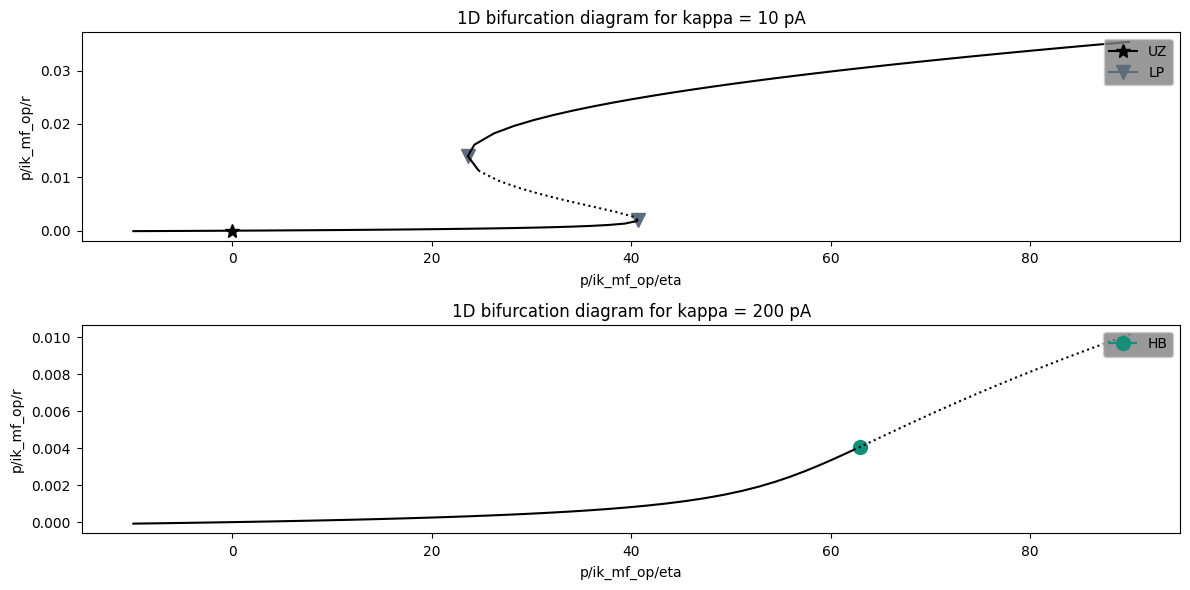

In [11]:
# perform a second contination in eta for kappa = 100
cont.run(starting_point="UZ1", origin="kappa", bidirectional=True, name="eta:2", ICP=vmap["eta"], 
         RL0=-10.0, RL1=90, UZR={}, STOP={}, DSMAX=0.02)

In [ ]:
# plot the bifurcation diagrams in eta for kappa = 10 and kappa = 200
_, axes = plt.subplots(nrows=2, figsize=(12, 6))
ax = axes[0]
cont.plot_continuation(vmap["eta"], vmap["r"], cont="eta:1", ax=ax)
plt.title("1D bifurcation diagram for kappa = 10 pA")
ax = axes[1]
cont.plot_continuation(vmap["eta"], vmap["r"], cont="eta:2", ax=ax)
plt.title("1D bifurcation diagram for kappa = 200 pA")
plt.tight_layout()
plt.show()

As we already expected, we see that, by increasing $\kappa$, the steady-state solution curve is not subject to fold bifurcations anymore.
Instead, it changes stability at a Hopf bifurcation (HB) as we increase $\eta$ beyond $60$ pA.
At a Hopf bifurcation, where a steady-state equilibrium changes stability, a branch of periodic solutions branches off that may be either stable (then the Hopf bifurcation is called supercritical) or unstable (a subcritical Hopf bifurcation).
We can switch onto this branch of periodic solutions at a Hopf bifurcation and continue it in $\eta$ as well, to see through which scenario the oscillations are generated that we observed in the previous network simulations.
We do this, by choosing different values for the continuation meta parameters `ISW`, `IPS`, and `ISP`:

In [13]:
# switch onto limit cycle branch and continue it in eta
_ = cont.run(name="eta:2:lc", origin="eta:2", starting_point="HB1", ICP=vmap["eta"], ISW=-1, IPS=2, ISP=2,
             STOP={"BP1", "LP2"})

Starting ik ...

  BR    PT  TY  LAB    PAR(9)        L2-NORM       MAX U(1)      MAX U(2)      MAX U(3)      MAX U(4)   
 136   100      161   6.30330E+01   5.31717E+01   4.74134E-03  -5.15718E+01   1.38882E+01   2.83880E-02
 136   200      162   6.31848E+01   5.33605E+01   5.45560E-03  -5.12352E+01   1.69713E+01   3.25979E-02
 136   300      163   6.33889E+01   5.36172E+01   6.14292E-03  -5.09520E+01   1.99322E+01   3.66362E-02
 136   400      164   6.36210E+01   5.39124E+01   6.80135E-03  -5.07078E+01   2.27394E+01   4.04919E-02
 136   500      165   6.38703E+01   5.42317E+01   7.43695E-03  -5.04908E+01   2.54082E+01   4.42008E-02
 136   600      166   6.41315E+01   5.45678E+01   8.05543E-03  -5.02934E+01   2.79577E+01   4.77965E-02
 136   700      167   6.44020E+01   5.49161E+01   8.66111E-03  -5.01103E+01   3.04038E+01   5.13043E-02
 136   800      168   6.46804E+01   5.52735E+01   9.25716E-03  -4.99380E+01   3.27583E+01   5.47424E-02
 136   900      169   6.49661E+01   5.56382E+0

Remember, that `ISW=-1` indicates that a switch of solution branches is to be performed at the Hopf bifurcation, whereas `IPS=2` indicates that a periodic solution is to be continued and `ISP=2` turns on the automatic detection of bifurcations on the periodic solution branch.
We can now depict the results of the periodic solution continuation together with the steady-state solution branch where the Hopf bifurcation was detected: 

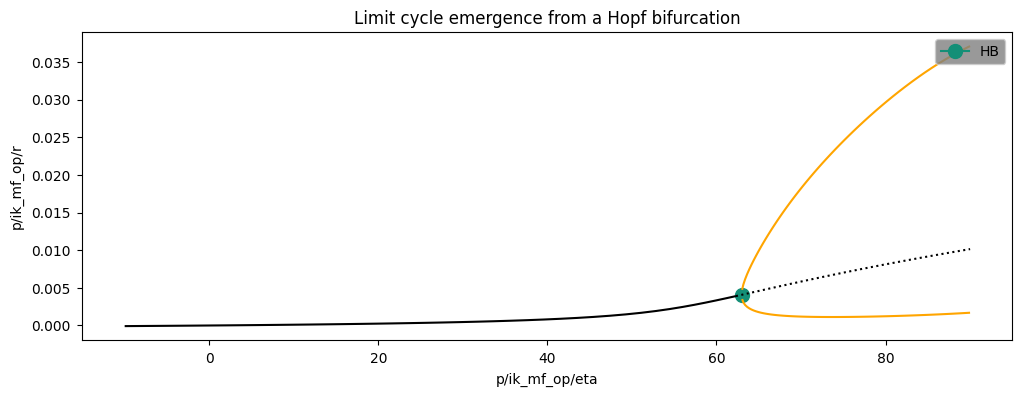

In [14]:
# plot the results
fig, ax = plt.subplots(figsize=(12, 4))
cont.plot_continuation(vmap["eta"], vmap["r"], cont="eta:2", ax=ax, line_color_stable="black")
cont.plot_continuation(vmap["eta"], vmap["r"], cont="eta:2:lc", ax=ax, line_color_stable='orange')
ax.set_title("Limit cycle emergence from a Hopf bifurcation")
plt.show()

In the plot above, the orange lines depict the minimum and maximum of the [periodic orbit](http://www.scholarpedia.org/article/Periodic_orbit) (also called limit cycle), i.e. the amplitudes of the oscillations that the mean-field equations would express in $r$ if the system converged to the limit cycle.
Indeed, the system would converge to the limit cycle, since we see in the bifurcation diagram that it is a stable limit cycle branch that emerges from the Hopf bifurcation.

<br/>

### (III) Two-parameter continuations of special solutions

<br/>

Now we have learned that we run into different bifurcations for low vs. high spike-frequency adaptation, even though we considered the exact same parameter range in the background input $\eta$. 
How does this change in the bifurcation structure come about? To understand what happens between the two cases $\kappa = 10$ pA and $\kappa = 100$ pA, we can compute a so-called locus of the Hopf and fold bifurcations that we detected in the entire 2D parameter space spanned by $\eta$ and $\kappa$. Think of these loci as curves of 1D bifurcations in a 2D parameter space.  

In order to compute these loci, we have to set `ISW=2`:

Starting ik ...

  BR    PT  TY  LAB    PAR(17)       L2-NORM         U(1)          U(2)          U(3)          U(4)        PAR(9)     
  30    50       76   6.01143E+00   5.49668E+01   1.99122E-03  -5.35056E+01  -1.25898E+01   1.19473E-02   4.04036E+01
  30   100       77   1.02777E+00   5.50699E+01   1.94927E-03  -5.35571E+01  -1.28191E+01   1.16956E-02   4.00763E+01
  30   111  EP   78  -6.87600E-02   5.50921E+01   1.94038E-03  -5.35682E+01  -1.28681E+01   1.16423E-02   4.00053E+01

 Total Time    0.414E-02
ik ... done
Starting ik ...

  BR    PT  TY  LAB    PAR(17)       L2-NORM         U(1)          U(2)          U(3)          U(4)        PAR(9)     
  30    50       76   1.39878E+01   5.47943E+01   2.06441E-03  -5.34189E+01  -1.21998E+01   1.23865E-02   4.09425E+01
  30   100       77   1.89684E+01   5.46811E+01   2.11451E-03  -5.33617E+01  -1.19399E+01   1.26871E-02   4.12893E+01
  30   150       78   2.39475E+01   5.45634E+01   2.16858E-03  -5.33017E+01  -1.16656E+01   1.30115E

 136  1233  BT  185   7.93724E+01   5.15303E+01   5.33696E-03  -5.14431E+01  -2.99487E+00   3.20218E-02   4.65304E+01

 Total Time    0.507E-01
ik ... done
Merge done


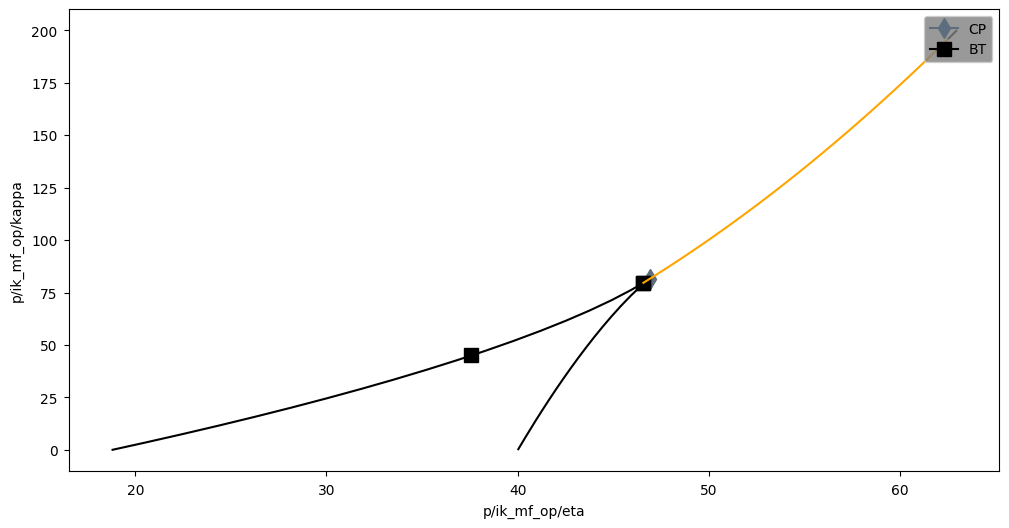

In [20]:
# calculate the locus of the first fold bifurcation in the eta-kappa parameter space
_ = cont.run(name="eta_kappa:fold", origin="eta:1", starting_point="LP1", bidirectional=True, ICP=[vmap["kappa"], vmap["eta"]], 
             ILP=0, IPS=1, ISW=2, NPR=50, RL0=0.0, RL1=200, DSMAX=0.1, NMX=8000)

# calculate the locus of the Hopf bifurcation in the eta-kappa parameter space
_ = cont.run(name="eta_kappa:hopf", origin="eta:2", starting_point="HB1", bidirectional=True, ICP=[vmap["kappa"], vmap["eta"]],
             ILP=0, IPS=1, ISW=2, NPR=50, RL0=0.0, RL1=200, DSMAX=0.1, NMX=8000)

In [ ]:
# plot the resulting 2D bifurcation diagram
fig, ax = plt.subplots(figsize=(12, 6))
cont.plot_continuation(vmap["eta"], vmap["kappa"], cont="eta_kappa:fold", ax=ax, line_color_stable="black", line_style_unstable="solid")
cont.plot_continuation(vmap["eta"], vmap["kappa"], cont="eta_kappa:hopf", ax=ax, line_color_stable='orange', line_style_unstable="solid")
plt.show()

From this 2D bifurcation diagram, we now learn how changes in $\kappa$ cause the fold bifurcations to vanish and the Hopf bifurcation to appear: By increasing $\kappa$, the two fold bifurcations approach each other and eventually anihilate each other in a so-called cusp bifurcation.
Along that process, the fold curve undergoes two [Bogdanov-Takens (BT) bifurcations](http://www.scholarpedia.org/article/Bogdanov-Takens_bifurcation). At a BT bifurcation, two fold bifurcation branches collide with a Hopf bifurcation branch. Thus, at the BT point, the periodic solution that we found was born.

<br/>

The Hopf curve that we identified for $\kappa = 200$ pA accounts for one of the BT bifurcations. 
But there is another BT bifurcation, for which we yet have to identify the Hopf bifurcation branch. 
Feel free to find that additional Hopf bifurcation yourself and compute its locus.
In order to do this, the following steps should lead to success:

1. identify a value of $\kappa$ in the vicinity of the BT bifurcation for which you are missing the Hopf branch.
2. Compute a solution for that value by running a one-parameter continuation in $\kappa$, starting from one of the two previous parameter continuations that we performed in $\eta$.
3. Run a one-parameter continuation in $\eta$ and see whether you encounter the expected Hopf bifurcation on the solution branch. If yes, proceed to 4, if no, redo all the steps from 1 with a different value for $\kappa$.
4. Compute the locus of the Hopf bifurcation in the $\eta$-$\kappa$ parameter space and plot all the solutions.

Just copy-paste some of the code from above for your solution into the cell below:

In [ ]:
# find the second Hopf bifurcation and compute its locus in the eta-kappa parameter space